In [56]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_core.runnables import RunnableConfig
from langchain_core.documents.base import Document
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import dotenv
import os

dotenv.load_dotenv()

True

In [57]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

embeddings = OpenAIEmbeddings()

In [58]:
path = "./files/rules/rules2/"
filename = os.listdir(path)

In [59]:
# 텍스트 스플리터 생성

splitter = RecursiveCharacterTextSplitter(chunk_size=100, 
                                          chunk_overlap=0,
                                          separators=["\n\n"])

In [60]:
# PDF 로더 생성

hr_loader = PyPDFLoader(path+filename[0])
security_loader = PyPDFLoader(path+filename[1])
onboard_loader = PyPDFLoader(path+filename[2])
tools_loader = PyPDFLoader(path+filename[3])
culture_loader = PyPDFLoader(path+filename[4])

In [61]:
# 문서 전처리 함수 생성

def cleaning_page(docs):
    docs = docs.load()
    lens = None
    for idx, doc in enumerate(docs):
        corpus = doc.page_content.replace("\xa0", "").replace("  ", " ").split("\n")
        if lens is None:
            lens = []
            for sentence in corpus:
                lens.append(len(sentence))
            length = sorted(lens)[len(lens)//2]
        else:
            pass

        cleaning_corpus = []
        for sentence in corpus[:-2]:
            if len(sentence) >= length:
                cleaning_corpus.append(sentence)
            else:
                cleaning_corpus.append(sentence+"\n\n")   
        docs[idx].page_content = "".join(cleaning_corpus)

    return docs

In [62]:
# 문서 전처리

hr_docs = cleaning_page(hr_loader)
security_docs = cleaning_page(security_loader)
onboard_docs = cleaning_page(onboard_loader)
tools_docs = cleaning_page(tools_loader)
culture_docs = cleaning_page(culture_loader)

In [63]:
# 텍스트 스플리터를 이용한 문서 분할

hr_docs = splitter.split_documents(hr_docs)
security_docs = splitter.split_documents(security_docs)
onboard_docs = splitter.split_documents(onboard_docs)
tools_docs = splitter.split_documents(tools_docs)
culture_docs = splitter.split_documents(culture_docs)

In [64]:
# 벡터스토어 생성

hr_vector_store = FAISS.from_documents(embedding=embeddings, documents=hr_docs)
security_vector_store = FAISS.from_documents(embedding=embeddings, documents=security_docs)
onboard_vector_store = FAISS.from_documents(embedding=embeddings, documents=onboard_docs)
tools_vector_store = FAISS.from_documents(embedding=embeddings, documents=tools_docs)
culture_vector_store = FAISS.from_documents(embedding=embeddings, documents=culture_docs)

In [65]:
# 리트리버 생성

hr_retriever = hr_vector_store.as_retriever()
security_retriever = security_vector_store.as_retriever()
onboard_retriever = onboard_vector_store.as_retriever()
tools_retriever = tools_vector_store.as_retriever()
culture_retriever = culture_vector_store.as_retriever()
compressor = LLMChainExtractor.from_llm(llm)

In [66]:
# LLM 기반 Reranker

hr_reranked = ContextualCompressionRetriever(
    base_retriever=hr_retriever,
    base_compressor=compressor
)

security_reranked = ContextualCompressionRetriever(
    base_retriever=security_retriever,
    base_compressor=compressor
)

onboard_reranked = ContextualCompressionRetriever(
    base_retriever=onboard_retriever,
    base_compressor=compressor
)

tools_reranked = ContextualCompressionRetriever(
    base_retriever=tools_retriever,
    base_compressor=compressor
)

culture_reranked = ContextualCompressionRetriever(
    base_retriever=culture_retriever,
    base_compressor=compressor
)

In [67]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    document : Annotated[Document, "Retrieve Response"]
    retrieval_type : Annotated[str, "Document Category"]

In [68]:
class RetriverChecker(BaseModel):
    """
    질문의 의도를 파악하고 5가지 주제 중 어디에 속하는지 답변합니다.
    당신이 가진 주제는 아래와 같습니다.

    1. 인사 운영 메뉴얼 : 회사의 인사 운영 원칙과 절차를 담은 매뉴얼입니다. 채용, 원격근무, 근로시간, 휴가, 평가, 복지, 퇴직 등 직원 전반의 라이프사이클을 공정하고 효율적으로 관리하기 위한 기준을 안내합니다.
    2. 보안 정책 : 회사의 정보 자산과 고객 데이터를 안전하게 보호하기 위한 보안 정책입니다. 계정 관리, 데이터 보안, 물리적 보안, 사고 대응, 보안 교육 등 전사적 보안 수칙을 담아 모든 임직원과 협력사가 따라야 할 기준을 안내합니다.
    3. 온보딩 메뉴얼 : 신규 입사자가 조직에 빠르게 적응하고 성과를 낼 수 있도록 돕는 온보딩 가이드입니다. 입사 전 준비부터 첫 3개월간의 일정, 교육, 피드백, 문화 적응까지 체계적인 지원 절차를 제공합니다.
    4. 업무 도구 가이드 : 회사에서 사용하는 주요 협업 도구의 사용 원칙과 규칙을 정리한 가이드입니다. 일관된 커뮤니케이션과 효율적인 협업을 위한 도구별 활용법과 팀 내 운영 기준을 안내합니다.
    5. 문화 규칙 : 우리 팀이 자연스럽게 지키는 협업과 소통의 문화 원칙입니다. 시간 약속, 수평적 호칭, 명확한 소통, 유대감 있는 잡담, 자율적 휴식, 책임 있는 결정 등 모두가 함께 일하기 좋은 팀 문화를 위한 10가지 약속을 담고 있습니다.

    질문이 1에 해당한다면 "HR", 2에 해당한다면 "Security", 3에 해당한다면 "Onboard", 4에 해당한다면 "Tools", 5에 해당한다면 "Culture"라는 답변을 반환합니다.

    """

    retrieval_type : Literal["HR", "Security", "Onboard", "Tools", "Culture"] = Field(..., description="""Identify the intent of the question and answer which of the five topics it belongs to.
The topics you have are as follows.

1. Personnel Management Manual: This is a manual that contains the company's personnel management principles and procedures. It guides the standards for fair and efficient management of the overall lifecycle of employees such as hiring, remote work, working hours, vacation, evaluation, welfare, and retirement.
2. Security Policy: A security policy to secure the company's information assets and customer data. It guides all executives and partners to follow with company-wide security rules such as account management, data security, physical security, incident response, and security training.
3. Onboarding Manual: This is an onboarding guide that helps new employees quickly adapt to the organization and achieve results. It provides a systematic support process from pre-employment preparation to the first three months of scheduling, training, feedback, and cultural adaptation.
4. Work Tool Guide: A guide that outlines the principles and rules of use of key collaborative tools used by the company. It guides you on how to use each tool for consistent communication and efficient collaboration and how to operate within the team.
5. Cultural Rules: The cultural principles of collaboration and communication that our team naturally follows. They contain 10 commitments for a team culture that is good for everyone to work with: time commitments, horizontal calling, clear communication, bonding small talk, autonomous rest, responsible decisions, etc.

Return "HR" if the question corresponds to 1, "Security" if it corresponds to 2, "Onboard" if it corresponds to 3, "Tools" if it corresponds to 4, and "Culture" if it corresponds to 5.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [69]:
retriever_checker = llm.with_structured_output(RetriverChecker)

In [70]:
result = retriever_checker.invoke("복지에는 어떤 것들이 있나요?")

In [71]:
result

RetriverChecker(retrieval_type='HR')

In [72]:
def retriever_check(state: State):
    prompt = PromptTemplate.from_template(
    """
    질문의 의도를 파악하고 5가지 주제 중 어디에 속하는지 답변합니다.
    당신이 가진 주제는 아래와 같습니다.

    1. 인사 운영 메뉴얼 : 회사의 인사 운영 원칙과 절차를 담은 매뉴얼입니다. 채용, 원격근무, 근로시간, 휴가, 평가, 복지, 퇴직 등 직원 전반의 라이프사이클을 공정하고 효율적으로 관리하기 위한 기준을 안내합니다.
    2. 보안 정책 : 회사의 정보 자산과 고객 데이터를 안전하게 보호하기 위한 보안 정책입니다. 계정 관리, 데이터 보안, 물리적 보안, 사고 대응, 보안 교육 등 전사적 보안 수칙을 담아 모든 임직원과 협력사가 따라야 할 기준을 안내합니다.
    3. 온보딩 메뉴얼 : 신규 입사자가 조직에 빠르게 적응하고 성과를 낼 수 있도록 돕는 온보딩 가이드입니다. 입사 전 준비부터 첫 3개월간의 일정, 교육, 피드백, 문화 적응까지 체계적인 지원 절차를 제공합니다.
    4. 업무 도구 가이드 : 회사에서 사용하는 주요 협업 도구의 사용 원칙과 규칙을 정리한 가이드입니다. 일관된 커뮤니케이션과 효율적인 협업을 위한 도구별 활용법과 팀 내 운영 기준을 안내합니다.
    5. 문화 규칙 : 우리 팀이 자연스럽게 지키는 협업과 소통의 문화 원칙입니다. 시간 약속, 수평적 호칭, 명확한 소통, 유대감 있는 잡담, 자율적 휴식, 책임 있는 결정 등 모두가 함께 일하기 좋은 팀 문화를 위한 10가지 약속을 담고 있습니다.

    질문이 1에 해당한다면 "HR", 2에 해당한다면 "Security", 3에 해당한다면 "Onboard", 4에 해당한다면 "Tools", 5에 해당한다면 "Culture"라는 답변을 반환합니다.

    질문 : {query}

    """
    )

    chain = prompt | retriever_checker

    result = chain.invoke({"query":state["query"]})

    return {"retrieval_type" : result.retrieval_type}

In [73]:
def reranker(state: State):

    if state["retrieval_type"] == "HR":
        docs = hr_reranked.invoke(state["query"])
        return {"document": docs}
    elif state["retrieval_type"] == "Security":
        docs = security_reranked.invoke(state["query"])
        return {"document": docs}
    elif state["retrieval_type"] == "Onboard":
        docs = onboard_reranked.invoke(state["query"])
        return {"document": docs}
    elif state["retrieval_type"] == "Tools":
        docs = tools_reranked.invoke(state["query"])
        return {"document": docs}
    else:
        docs = culture_reranked.invoke(state["query"])
        return {"document": docs}

In [74]:
def response(state: State):
    prompt = ChatPromptTemplate([
        ("system", "당신은 회사 내규 챗봇입니다. 사용자 정보와 회사 내규 문서가 주어집니다. 그것을 통해 사용자의 행동을 제시하세요.\n"
                "---"
                "문서 : {context}\n\n"
                "문서에서 응답을 찾을 수 없는 경우 '문서에서 응답을 찾을 수 없습니다.' 라고 답변하세요."), 
        ("user", "{query}")
        ])
    
    docs = "\n\n".join(doc.page_content for doc in state["document"])
    
    chain = prompt | llm

    result = chain.invoke({"context":docs,
                           "query":state["query"]})
    
    return {"answer":result}

In [75]:
graph_builder = StateGraph(State)

In [76]:
graph_builder.add_node("retriever_check", retriever_check)
graph_builder.add_node("reranker", reranker)
graph_builder.add_node("response", response)

graph_builder.add_edge(START, "retriever_check")
graph_builder.add_edge("retriever_check", "reranker")
graph_builder.add_edge("reranker", "response")
graph_builder.add_edge("response", END);

In [ ]:
graph = graph_builder.compile()

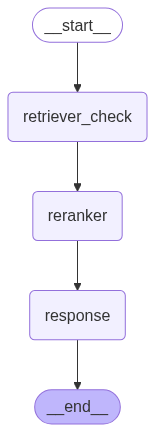

In [78]:
graph

In [92]:
result = graph.stream({"query": "우리 회사에는 어떤 복지제도가 있나요?"})

In [93]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        if k != "response":
            print(v)
        else:
            print(v["answer"].content)



=== retriever_check ===


{'retrieval_type': 'HR'}


=== reranker ===


{'document': [Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-06-20T10:32:30+00:00', 'title': '1. 인사 운영 메뉴얼', 'moddate': '2025-06-20T10:32:30+00:00', 'source': './files/rules/rules2/1._인사_운영_메뉴얼.pdf', 'total_pages': 5, 'page': 2, 'page_label': '3'}, page_content='복지 제도 : 직원들의 업무 만족도와 복지를 위해 다음과 같은 제도를 운영합니다 : 점심 식대 지원 , 간식 · 커피 무제한 제공 , 의료검진 지원 , 자기계발비 또는 도서구입비 지원 , 사내 동호회 지원 등 .'), Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-06-20T10:32:30+00:00', 'title': '1. 인사 운영 메뉴얼', 'moddate': '2025-06-20T10:32:30+00:00', 'source': './files/rules/rules2/1._인사_운영_메뉴얼.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}, page_content

In [ ]:
result = graph.invoke({"query": "원격근무는 언제 할 수 있나요?"})

In [95]:
result

{'query': '재택근무는 언제 할 수 있나요?',
 'answer': AIMessage(content='원격근무는 주 2 회까지 허용하여 업무 효율과 워라밸을 지원합니다. 따라서 재택근무는 주 2 회 이내로 가능합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 117, 'total_tokens': 157, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-5255b545-29d7-4813-9400-e0c747950b60-0', usage_metadata={'input_tokens': 117, 'output_tokens': 40, 'total_tokens': 157, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'document': [Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0

In [97]:
result = graph.stream({"query": "퇴사를 계획중인데 어떻게 하면 되나요?"})

In [98]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        if k != "response":
            print(v)
        else:
            print(v["answer"].content)



=== retriever_check ===


{'retrieval_type': 'HR'}


=== reranker ===


{'document': [Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-06-20T10:32:30+00:00', 'title': '1. 인사 운영 메뉴얼', 'moddate': '2025-06-20T10:32:30+00:00', 'source': './files/rules/rules2/1._인사_운영_메뉴얼.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}, page_content='퇴사 통보 : 직원이 자발적으로 퇴사하고자 할 경우 , 인수인계를 고려하여 최소 4 주 이전에 퇴사 의사를 통보하는 것을 권장합니다 . 퇴사 신청은 퇴직 의사 확인서 제출을 통해 공식화되며 , 팀 리더 및 HR 과 면담을 거칩니다 .')]}


=== response ===


퇴사를 계획하고 계신다면, 다음 단계를 따라 주시기 바랍니다:

1. 최소 4주 이전에 퇴사 의사를 통보하는 것이 권장됩니다. 이는 인수인계를 고려한 것입니다.
2. 퇴사 신청은 퇴직 의사 확인서를 제출하여 공식화해야 합니다.
3. 팀 리더 및 HR과 면담을 진행해야 합니다.

이 과정을 통해 퇴사를 원활하게 진행할 수 있습니다.


In [107]:
result = graph.stream({"query": "회사 계정의 비밀번호는 어떤 규칙대로 만들어야하나요?"})

In [108]:
for step in result:
    for k,v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        if k != "response":
            print(v)
        else:
            print(v["answer"].content)



=== retriever_check ===


{'retrieval_type': 'Security'}


=== reranker ===


{'document': [Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-06-20T08:17:52+00:00', 'title': '2. 보안 정책', 'moddate': '2025-06-20T08:17:52+00:00', 'source': './files/rules/rules2/2._보안_정책.pdf', 'total_pages': 5, 'page': 1, 'page_label': '2'}, page_content='비밀번호는 최소 12 자 이상이어야 하며 대문자 , 소문자 , 숫자 , 특수문자를 각각 1 자 이상 포함해야 합니다 . 비밀번호는 90일마다 주기적 변경을 권고하고 동일 비밀번호를 재사용하지 않습니다 . 중요한 시스템의 경우 최근 5 개 이전 비밀번호와 다른 값으로 변경해야 합니다 .'), Document(metadata={'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-06-20T08:17:52+00:00', 'title': '2. 보안 정책', 'moddate': '2025-06-20T08:17:52+00:00', 'source': './files/rules/rules2/2._보안_정책.pdf', 'total_pages': 5, 'page': 2, '